# Project Part A


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os
import importlib
import scipy.io as sio

# Add path to tsa_lth library
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main')))

# Import and reload to get the latest changes
import tsa_lth.analysis
import tsa_lth.modelling
import tsa_lth.tests
importlib.reload(tsa_lth.analysis)
importlib.reload(tsa_lth.modelling)
importlib.reload(tsa_lth.tests)

from tsa_lth.analysis import plotACFnPACF, normplot, xcorr, pzmap, kovarians
from tsa_lth.modelling import estimateARMA, polydiv
from tsa_lth.tests import whiteness_test, check_if_normal


import pandas as pd
import scipy.io as sio

mat_data = sio.loadmat('../data/projectData25.mat')
data = mat_data['data']

cols = [
    'obs_num', 'power_MJ_s', 'ambient_temp_C', 'supply_temp_C',
    'year', 'month', 'day', 'hour'
]

df = pd.DataFrame(data[:, :8], columns=cols)


## Basic Checking of the data

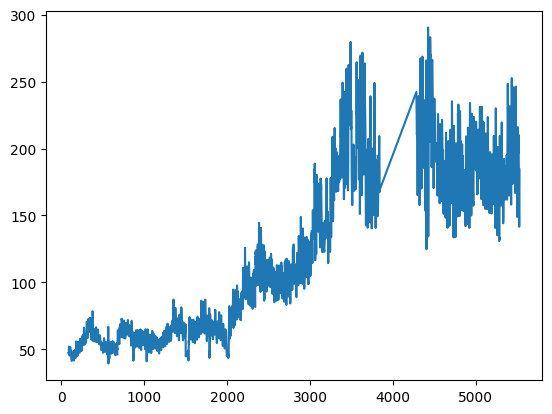

In [ ]:
# Some Code
idxs = df['obs_num'].values
y = df['power_MJ_s'].values

plt.figure()
plt.plot(idxs, y, label='power data')

# Notice there is a large gap at one point. We must deal with this in some way. There aren't any obvious outliers but maybe we
# should check this anyways

## Outliers
We'll have to do something about that huge gap with no data but we leave it for later

In [ ]:
# Some Code



# Correlation with inputs

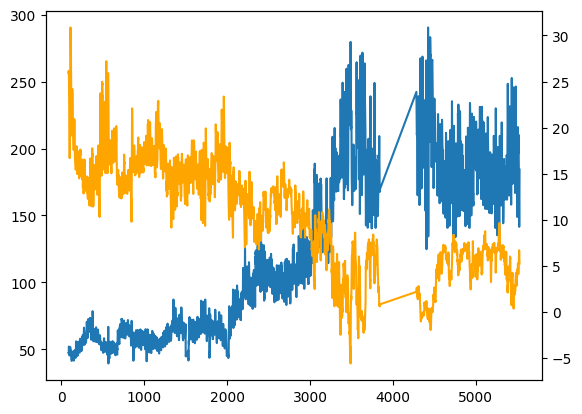

In [ ]:
x = df['ambient_temp_C'].values

fig, ax = plt.subplots()
ax.plot(idxs, y)
ax2 = ax.twinx()
ax2.plot(idxs, x, color='orange')

# Clearly there is a significant correlation

# Transformations
The box-cox plot indicates a peak near 0, which means we should probably do a log transformation

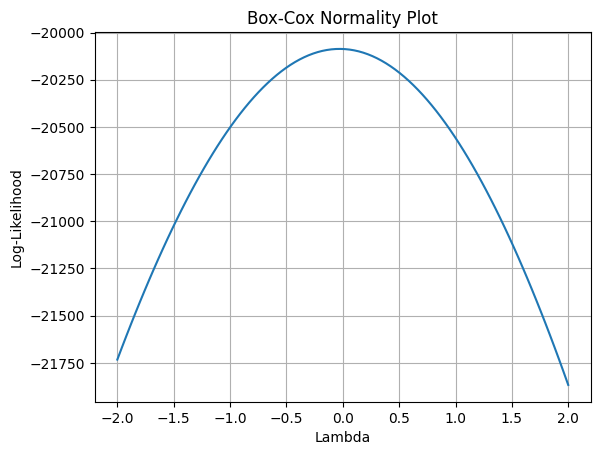

The Box-Cox curve is maximized at -0.03


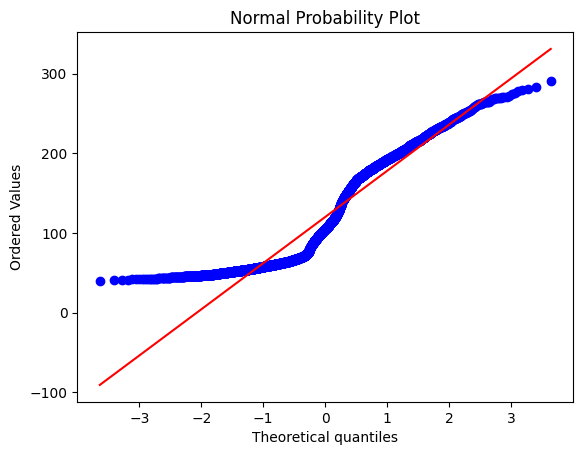

In [44]:
# Use the packaged Box-Cox helper (returns lambda and offset when transform=False)
from tsa_lth.analysis import box_cox
from scipy import stats


lambda_max, offsetValue = box_cox(y, plotIt=True, transform=False)
print(f'The Box-Cox curve is maximized at {lambda_max:4.2f}')

plt.figure()
stats.probplot(y, dist="norm", plot=plt)
plt.title('Normal Probability Plot')
plt.show()


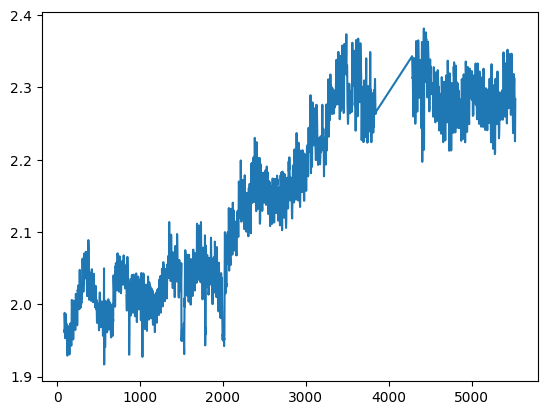

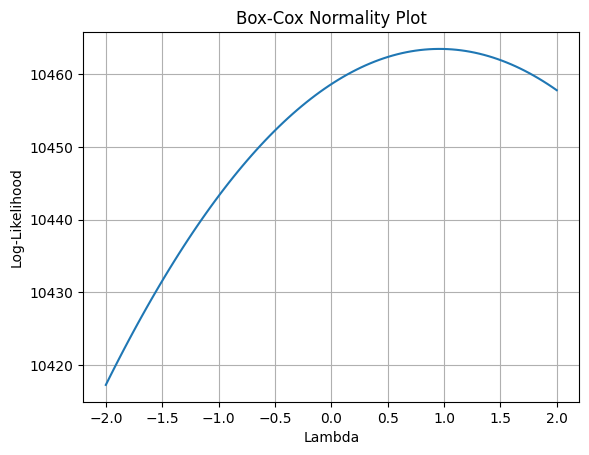

The Box-Cox curve is maximized at 0.96


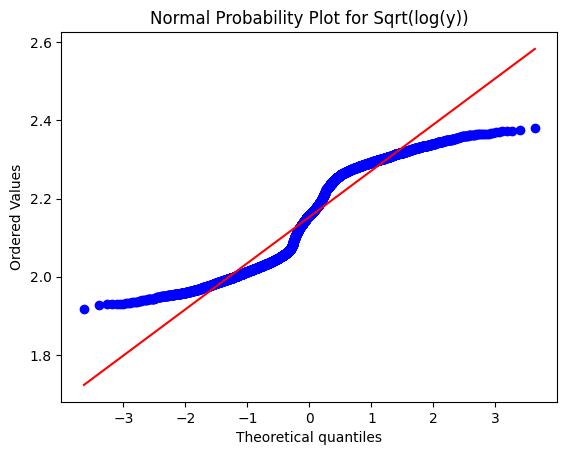

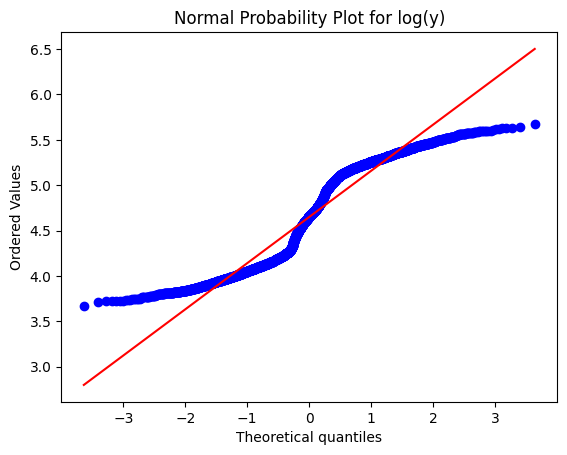

In [ ]:
log_y = np.log(y)
# plt.figure()
# plt.plot(idxs, log_y)
# plt.show()

# lambda_max, offsetValue = box_cox(log_y, plotIt=True, transform=False)
# print(f'The Box-Cox curve is maximized at {lambda_max:4.2f}')

# plt.figure()
# stats.probplot(log_y, dist="norm", plot=plt)
# plt.title('Normal Probability Plot')
# plt.show()


sqrt_log_y = np.sqrt(log_y)
plt.figure()
plt.plot(idxs, sqrt_log_y)
plt.show()

lambda_max, offsetValue = box_cox(sqrt_log_y, plotIt=True, transform=False)
print(f'The Box-Cox curve is maximized at {lambda_max:4.2f}')

plt.figure()
stats.probplot(sqrt_log_y, dist="norm", plot=plt)
plt.title('Normal Probability Plot for Sqrt(log(y))')
plt.show()

plt.figure()
stats.probplot(log_y, dist="norm", plot=plt)
plt.title('Normal Probability Plot for log(y)')
plt.show()


# Could be interesting to try sqrt(log(y)) but lets do that later


# Extract Modeling set

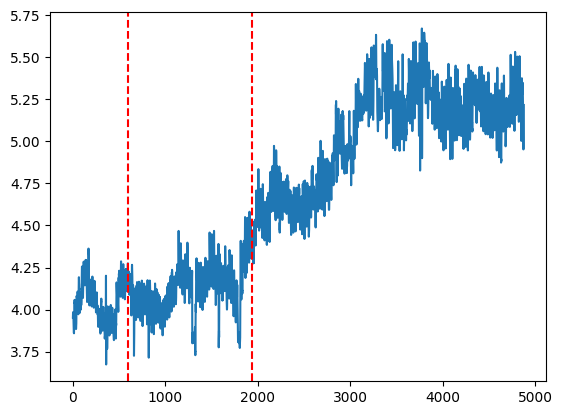

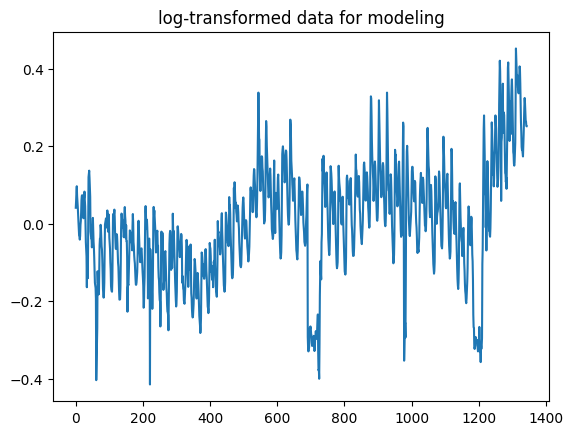

Text(0.5, 1.0, 'Filtered input for modeling')

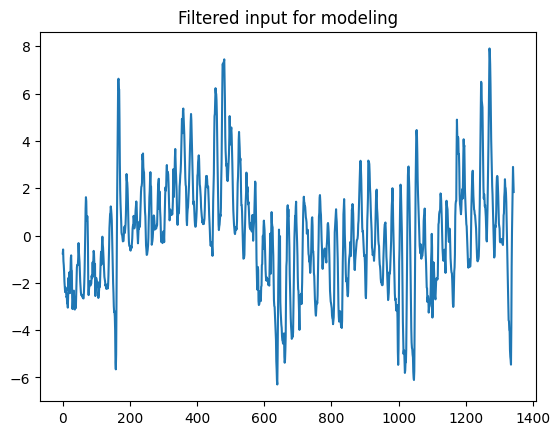

In [95]:
first = 600
last = first + 168*8 - 1          
model_data = log_y[first:last+1]
model_input = x[first:last+1]

plt.figure()
plt.plot(log_y)
plt.axvline(first, linestyle='--', color='red')
plt.axvline(last, linestyle='--', color='red')



# Transforming input
filt_x = signal.lfilter([1, *np.zeros(23), -1], 1, x)
filt_x = x
trm_x = filt_x[first:last + 1] - np.mean(filt_x[first: last + 1]) # Transformed and modeling input

# Transforming output
trm_y = log_y[first:last + 1] - np.mean(log_y[first:last + 1]) # Transformed and modeling output


# Throw away data and keep lengths consistent
filt_x = filt_x[24:]             # remove first 24 invalid points
log_y = log_y[24:]               # keep lengths consistent



plt.figure()
plt.plot(trm_y)
plt.title('log-transformed data for modeling')
plt.show()

plt.figure()
plt.plot(trm_x)
plt.title('Filtered input for modeling')


# Model input as ARMA

Discrete-time ARMA model: A(z)∇₂₄y(t) = C(z)e(t)

A(z) = 1.0 - 1.4086(±0.0247)·z⁻¹ + 0.464(±0.0247)·z⁻² - 0.027(±0.007)·z⁻²⁴
C(z) = 1.0 - 0.939(±0.0101)·z⁻²⁴

Polynomial orders: nA = 24    nC = 24
Number of free coefficients: 4
Fit to estimation data (NRMSE): 82.54%
FPE : 0.17  MSE : 0.169
AIC : 1405.946   BIC : 1426.688



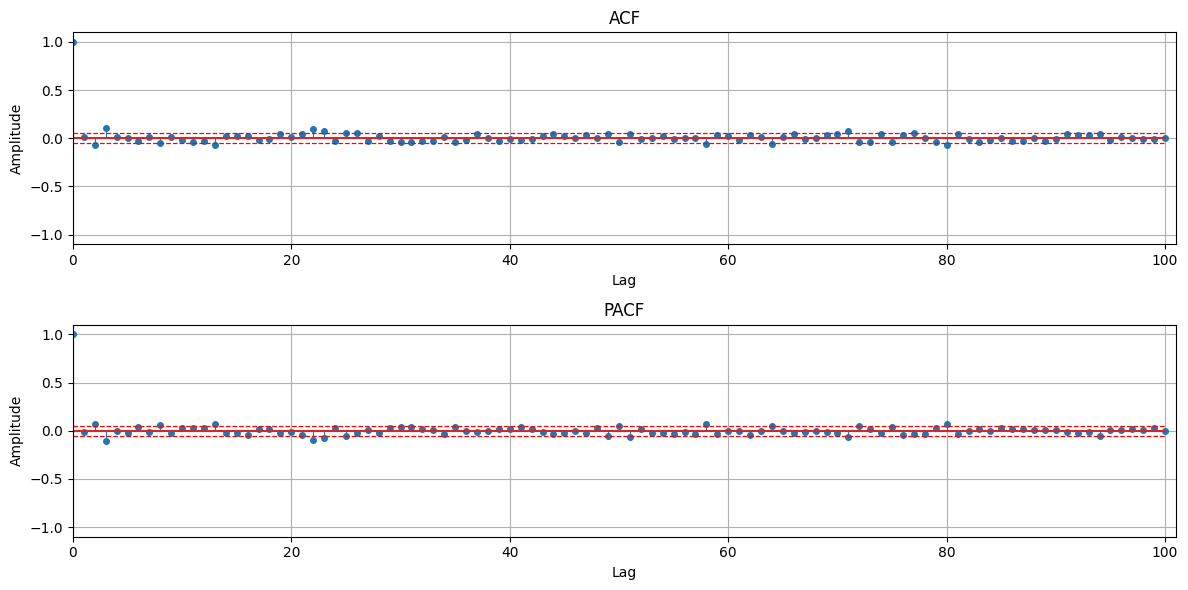

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 72.73 < 37.65)
  McLeod-Li test:        False (white if 118.00 < 37.65)
  Monti test:            False (white if 76.22 < 37.65)
  Sign change test:      False (white if 0.45 in [0.47,0.53])


In [ ]:
### WARNING! I DID THIS WHOLE PART WITH THE FILTERED INPUT. CHECK IF ONE CAN FILTER THE INPUT, MAYBE THAT IS WRONG TO DO!!!

from tsa_lth.modelling import estimateARMA

noLags = 200
# plotACFnPACF(trm_x, noLags=200, titleStr='Data') 
# Here I see a very clear 24 periodicity despite the original filtering: lets try adding that season

# my_input_arma = estimateARMA(trm_x, A=0, C=0, diff=24, A_free=None, C_free=None, titleStr='', noLags=100, method='LS', bh=False, plot=True)
# Still strong ringing and strong values now at 25, but also the first 3. For simplicty, we try the 3 A-parameters and see what happens

# my_input_arma = estimateARMA(trm_x, A=3, C=0, diff=24, A_free=[1, 1, 1, 1], C_free=None, titleStr='', noLags=100, method='LS', bh=False, plot=True)
# Still super strong periodicity at 24: lets try adding a C-24 while keeping othe params frozen

# my_input_arma = estimateARMA(trm_x, A=3, C=24, diff=24, A_free=[1, 1, 1, 1], C_free=[1, *np.zeros(23), 1], titleStr='', noLags=100, method='LS', bh=False, plot=True)
# Still the 24 hour cycle, lets add an A-24 and see what happens


# my_input_arma = estimateARMA(trm_x, A=24, C=24, diff=24, A_free=[1, 1, 1, 1, *np.zeros(20), 1], C_free=[1, *np.zeros(23), 1], titleStr='', noLags=100, method='LS', bh=False, plot=True)
# Still see a strong values around 24-26. Maybe I'll add those as well and see if the 25 or 26 helps the 24-cycle


# my_input_arma = estimateARMA(trm_x, A=26, C=24, diff=24, A_free=[1, 1, 1, 1, *np.zeros(20), 1, 1, 1], C_free=[1, *np.zeros(23), 1], titleStr='', noLags=100, method='LS', bh=False, plot=True)
# They became less significant. Lets try removing the seasons diff

# my_input_arma = estimateARMA(trm_x, A=26, C=24, diff=0, A_free=[1, 1, 1, 1, *np.zeros(20), 1, 1, 1], C_free=[1, *np.zeros(23), 1], titleStr='', noLags=100, method='LS', bh=False, plot=True)
# Not actually white but damn close I have to say. Maybe it was wrong of me to try with the diff when i had already transformed the x in the beginning. See if I can get away with taking away some params

# my_input_arma = estimateARMA(trm_x, A=24, C=24, diff=0, A_free=[1, 1, 1, 1, *np.zeros(20), 1,], C_free=[1, *np.zeros(23), 1], titleStr='', noLags=100, method='LS', bh=False, plot=True)
# Even better than before, really close to white!

my_input_arma = estimateARMA(trm_x, A=24, C=24, diff=0, A_free=[1, 1, 1, *np.zeros(21), 1,], C_free=[1, *np.zeros(23), 1], titleStr='', noLags=100, method='LS', bh=False, plot=True)
# Removed a param and basically same Monti whiteness level, close enough to white. Lets keep this model


In [ ]:
### WARNING! CREATING ARMA MODEL FOR THE UN-FILTERED X. Tried 

x = 


# Differentiate data based on daily cycle

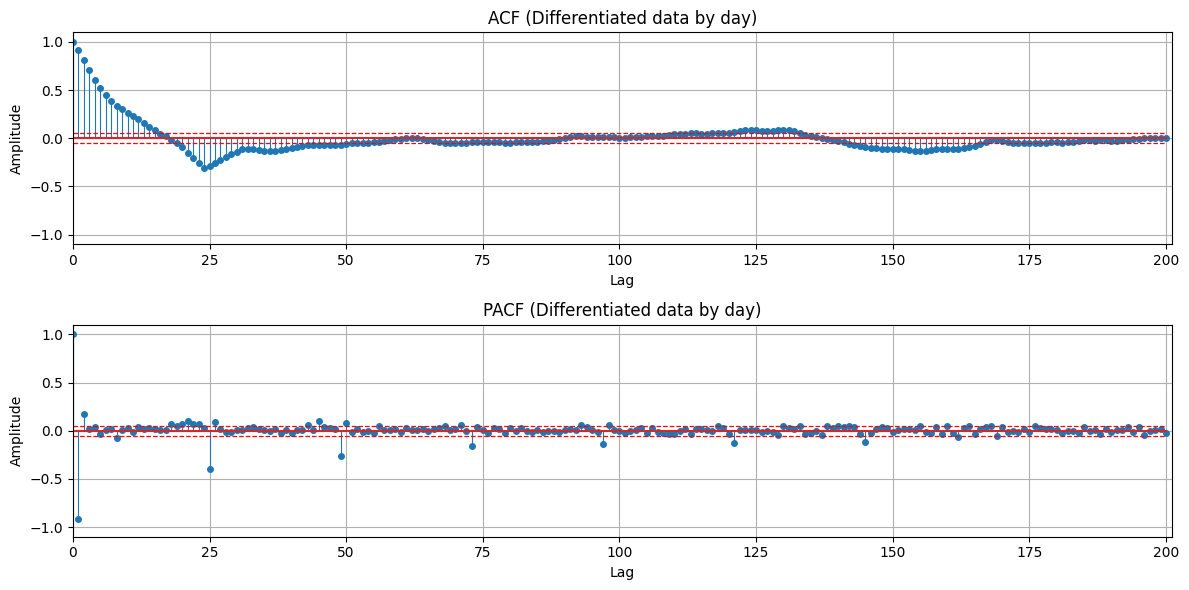

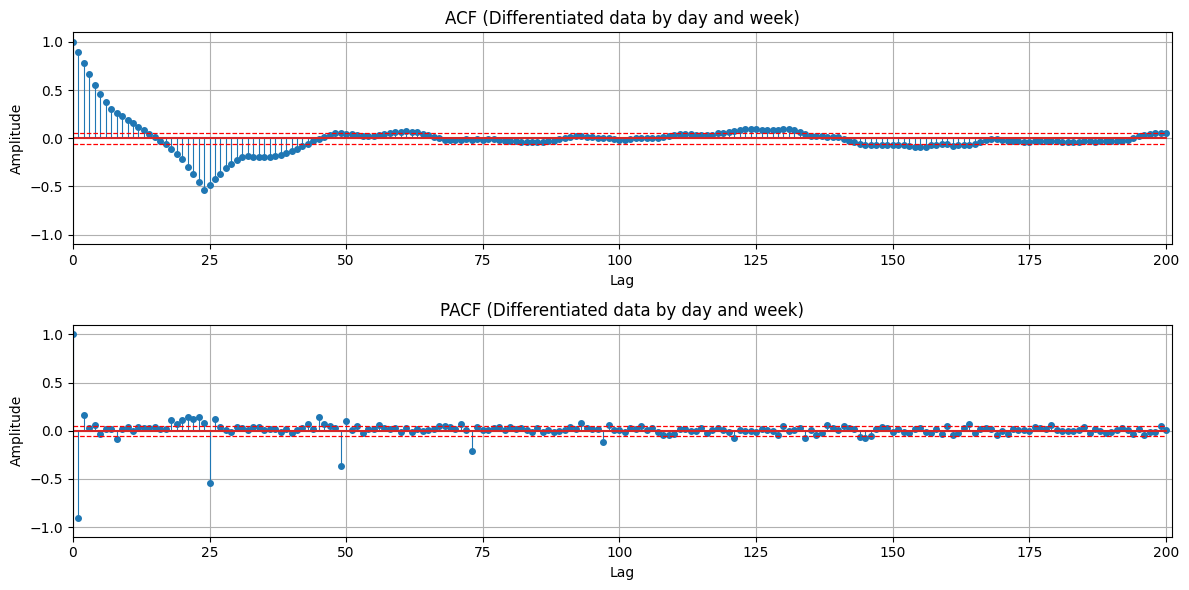

In [41]:
from tsa_lth.modelling import PEM, filter as tsa_filter

sday = 24
dayPoly = np.concatenate([[1], np.zeros(sday-1), [-1]])

dayfilt_model_data = tsa_filter(dayPoly, 1, model_data, remove=True)
_=plotACFnPACF(dayfilt_model_data, noLags, 'Differentiated data by day')

sweek = 24
weekPoly = np.concatenate([[1], np.zeros(sweek-1), [-1]])
filt_model_data = tsa_filter(weekPoly, 1, dayfilt_model_data, remove=True)
_=plotACFnPACF(filt_model_data, noLags, 'Differentiated data by day and week')